<a href="https://colab.research.google.com/github/VinaySingh561/123/blob/master/Node_classification_new23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install deeprobust
# !conda install pytorch torchvision torchaudio -c pytorch
import torch
# print(torch.__version__)
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.generators.random_graphs import barabasi_albert_graph
from networkx.generators.community import stochastic_block_model
from networkx.generators.random_graphs import watts_strogatz_graph
from networkx.generators.community import random_partition_graph

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import math
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import FactorAnalysis

import random



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 31.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 1.2 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=d33dcf6c22b845c1b7f06f0654da464f3b168d2f8d61a04771927dce81d5b5a0
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  Attempting uninstall: psutil
    Found existing installation:

In [2]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

In [3]:
import numpy
import torch
%load_ext autoreload
%autoreload 2

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))



from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.generators.random_graphs import barabasi_albert_graph
from networkx.generators.community import stochastic_block_model
from networkx.generators.random_graphs import watts_strogatz_graph
from networkx.generators.community import random_partition_graph
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import math
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import FactorAnalysis
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from random import sample

In [5]:
# from deeprobust.graph.data import Dataset

In [6]:
from scipy.sparse import csr_matrix
from scipy.sparse import csgraph
from scipy.sparse.linalg import inv

In [7]:
import os
os.getcwd()

'/content'

In [8]:
dataset = os.path.join(os.getcwd(),'Texas')
dataset

'/content/Texas'

In [9]:
from torch_geometric.datasets import WebKB
from torch_geometric.utils import to_dense_adj,homophily


dataset = WebKB(root='/Texas',name='Texas')
print(dataset[0])

edge_list = dataset[0].edge_index
NO_OF_EDGES = edge_list.shape[1]
labels = dataset[0].y

print("Homophilic ratio : " + str(homophily(edge_list,labels,method='edge')))


adj = to_dense_adj(dataset[0].edge_index)
adj = adj[0]

labels = labels.numpy()

X = dataset[0].x
X = X.to_dense()
N = X.shape[0]
NO_OF_CLASSES = 5

sparsity_original = 2*NO_OF_EDGES/(N*(N-1))
print("Sparsity of original graph : " + str(sparsity_original))


print(X.shape, adj.shape)

nn = int(1*N)
X = X[:nn,:]
adj = adj[:nn,:nn]
labels = labels[:nn]
print(X.shape,adj.shape)

# plot_graph(dataset[0])


Processing...


Data(x=[183, 1703], edge_index=[2, 325], y=[183], train_mask=[183, 10], val_mask=[183, 10], test_mask=[183, 10])
Homophilic ratio : 0.10769230872392654
Sparsity of original graph : 0.0195160031225605
torch.Size([183, 1703]) torch.Size([183, 183])
torch.Size([183, 1703]) torch.Size([183, 183])


Done!


In [10]:
def get_laplacian(adj):
    b=torch.ones(adj.shape[0])
    return torch.diag(adj@b)-adj

theta = get_laplacian(adj)
print(theta.shape)


torch.Size([183, 183])


In [11]:
# dataset_name = 'flickr' 

# data = Dataset(root='', name=dataset_name, setting='gcn',seed=10)

# adj, features, labels = data.adj, data.features, data.labels
# idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

# theta = csgraph.laplacian(adj).tocsr()
features = X.numpy()
NO_OF_NODES = X.shape[0]
# NO_OF_CLASSES =  7


print(NO_OF_CLASSES,NO_OF_NODES)

5 183


In [12]:
def convertScipyToTensor(coo):
  try:
    coo = coo.tocoo()
  except:
    coo = coo
  values = coo.data
  indices = np.vstack((coo.row, coo.col))

  i = torch.LongTensor(indices)
  v = torch.FloatTensor(values)
  shape = coo.shape

  return torch.sparse.FloatTensor(i, v, torch.Size(shape))

In [13]:
from scipy.sparse import random
from scipy.sparse.linalg import norm
from scipy.sparse import csr_matrix

p = X.shape[0]
k = int(p*0.5)
n = X.shape[1]
lambda_param = 100
beta_param = 50
alpha_param = 100
gamma_param = 100
lr = 1e-5
thresh = 1e-10

from scipy.sparse import random
from scipy.stats import rv_continuous
class CustomDistribution(rv_continuous):
    def _rvs(self,  size=None, random_state=None):
        return random_state.standard_normal(size)
temp = CustomDistribution(seed=1)
temp2 = temp()  # get a frozen version of the distribution
X_tilde = random(k, n, density=0.25, random_state=1, data_rvs=temp2.rvs)
C = random(p, k, density=0.25, random_state=1, data_rvs=temp2.rvs)



In [14]:
def experiment(lambda_param,beta_param,alpha_param,gamma_param,C,X_tilde,theta,X):
      p = X.shape[0]
      k = int(p*0.5)
      n = X.shape[1]
      ones = csr_matrix(np.ones((k,k)))
      ones = convertScipyToTensor(ones)
      ones = ones.to_dense()
      J = np.outer(np.ones(k), np.ones(k))/k
      J = csr_matrix(J)
      J = convertScipyToTensor(J)
      J = J.to_dense()
      zeros = csr_matrix(np.zeros((p,k)))
      zeros = convertScipyToTensor(zeros)
      zeros = zeros.to_dense()
      X_tilde = convertScipyToTensor(X_tilde)
      X_tilde = X_tilde.to_dense()
      C = convertScipyToTensor(C)
      C = C.to_dense()
      eye = torch.eye(k)
      try:
        theta = convertScipyToTensor(theta)
      except:
        theta = theta
      try:
        X = convertScipyToTensor(X)
        X = X.to_dense()
      except:
        X = X

      if(torch.cuda.is_available()):
        # print("yes")
        X_tilde = X_tilde.cuda()
        C = C.cuda()
        theta = theta.cuda()
        X = X.cuda()
        J = J.cuda()
        zeros = zeros.cuda()
        ones = ones.cuda()
        eye = eye.cuda()

      def update(X_tilde,C,i):
          global L
          thetaC = theta@C
          CT = torch.transpose(C,0,1)
          X_tildeT = torch.transpose(X_tilde,0,1)
          CX_tilde = C@X_tilde
          t1 = CT@thetaC + J
          term_bracket = torch.linalg.pinv(t1)
          thetacX_tilde = thetaC@(X_tilde)
          
          L = 1/k

          t1 = -2*gamma_param*(thetaC@term_bracket)
          t2 = alpha_param*(CX_tilde-X)@(X_tildeT)
          t3 = 2*thetacX_tilde@(X_tildeT)
          t4 = lambda_param*(C@ones)
          t5 = 2*beta_param*(thetaC@CT@thetaC)
          T2 = (t1+t2+t3+t4+t5)/L
          Cnew = (C-T2).maximum(zeros)
          t1 = CT@thetaC*(2/alpha_param)
          t2 = CT@C
          t1 = torch.linalg.pinv(t1+t2)
          t1 = t1@CT
          t1 = t1@X
          X_tilde_new = t1
          Cnew[Cnew<thresh] = thresh
          for i in range(len(Cnew)):
              Cnew[i] = Cnew[i]/torch.linalg.norm(Cnew[i],1)
          for i in range(len(X_tilde_new)):
            X_tilde_new[i] = X_tilde_new[i]/torch.linalg.norm(X_tilde_new[i],1)
          return X_tilde_new,Cnew


      for i in tqdm(range(20)):
          X_tilde,C = update(X_tilde,C,i)
    
      return X_tilde,C




In [15]:
def experiment2(lambda_param,beta_param,alpha_param,gamma_param,C,X_tilde,theta,X):
      p = X.shape[0]
      k = int(p*0.1)
      n = X.shape[1]
      ones = csr_matrix(np.ones((k,k)))
      ones = convertScipyToTensor(ones)
      ones = ones.to_dense()
      J = np.outer(np.ones(k), np.ones(k))/k
      J = csr_matrix(J)
      J = convertScipyToTensor(J)
      J = J.to_dense()
      zeros = csr_matrix(np.zeros((p,k)))
      zeros = convertScipyToTensor(zeros)
      zeros = zeros.to_dense()
      X_tilde = convertScipyToTensor(X_tilde)
      X_tilde = X_tilde.to_dense()
      C = convertScipyToTensor(C)
      C = C.to_dense()
      eye = torch.eye(k)
      try:
        theta = convertScipyToTensor(theta)
      except:
        theta = theta
      try:
        X = convertScipyToTensor(X)
        X = X.to_dense()
      except:
        X = X

      if(torch.cuda.is_available()):
        # print("yes")
        X_tilde = X_tilde.cuda()
        C = C.cuda()
        theta = theta.cuda()
        X = X.cuda()
        J = J.cuda()
        zeros = zeros.cuda()
        ones = ones.cuda()
        eye = eye.cuda()

      def update(X_tilde,C,i):
          global L
          thetaC = theta@C
          CT = torch.transpose(C,0,1)
          X_tildeT = torch.transpose(X_tilde,0,1)
          CX_tilde = C@X_tilde
          t1 = CT@thetaC + J
          term_bracket = torch.linalg.pinv(t1)
          thetacX_tilde = thetaC@(X_tilde)
          CTX = CT@X
          
          L = 1/k

          t1 = -2*gamma_param*(thetaC@term_bracket)
          t2 = alpha_param*X@((X_tilde - CTX).T)
          # t3 = 2*thetacX_tilde@(X_tildeT)
          t3 = zeros
          t4 = lambda_param*(C@ones)
          t5 = 2*beta_param*(thetaC@CT@thetaC)
          T2 = (t1+t2+t3+t4+t5)/L
          Cnew = (C-T2).maximum(zeros)
          t1 = CT@thetaC*(2/alpha_param)
          t2 = CT@C
          t1 = torch.linalg.pinv(t1+t2)
          t1 = t1@CT
          t1 = t1@X
          X_tilde_new = CTX
          Cnew[Cnew<thresh] = thresh
          for i in range(len(Cnew)):
              Cnew[i] = Cnew[i]/torch.linalg.norm(Cnew[i],1)
          for i in range(len(X_tilde_new)):
            X_tilde_new[i] = X_tilde_new[i]/torch.linalg.norm(X_tilde_new[i],1)
          return X_tilde_new,Cnew


      for i in tqdm(range(25)):
          X_tilde,C = update(X_tilde,C,i)
    
      return X_tilde,C




In [16]:
def experiment3(lambda_param,beta_param,alpha_param,gamma_param,C,X_tilde,theta,X):
      p = X.shape[0]
      k = int(p*0.1)
      n = X.shape[1]
      ones = csr_matrix(np.ones((k,k)))
      ones = convertScipyToTensor(ones)
      ones = ones.to_dense()
      J = np.outer(np.ones(k), np.ones(k))/k
      J = csr_matrix(J)
      J = convertScipyToTensor(J)
      J = J.to_dense()
      zeros = csr_matrix(np.zeros((p,k)))
      zeros = convertScipyToTensor(zeros)
      zeros = zeros.to_dense()
      X_tilde = convertScipyToTensor(X_tilde)
      X_tilde = X_tilde.to_dense()
      C = convertScipyToTensor(C)
      C = C.to_dense()
      eye = torch.eye(k)
      try:
        theta = convertScipyToTensor(theta)
      except:
        theta = theta
      try:
        X = convertScipyToTensor(X)
        X = X.to_dense()
      except:
        X = X

      if(torch.cuda.is_available()):
        # print("yes")
        X_tilde = X_tilde.cuda()
        C = C.cuda()
        theta = theta.cuda()
        X = X.cuda()
        J = J.cuda()
        zeros = zeros.cuda()
        ones = ones.cuda()
        eye = eye.cuda()

      def update(X_tilde,C,i):
          global L,adj
          thetaC = theta@C
          CT = torch.transpose(C,0,1)
          X_tildeT = torch.transpose(X_tilde,0,1)
          CX_tilde = C@X_tilde
          t1 = CT@thetaC + J
          term_bracket = torch.linalg.pinv(t1)
          thetacX_tilde = thetaC@(X_tilde)
          
          L = 1/k

          t1 = -2*gamma_param*(thetaC@term_bracket)
          t2 = alpha_param*(CX_tilde-X)@(X_tildeT)
          t3 = 2*thetacX_tilde@(X_tildeT)
          t4 = lambda_param*(C@ones)
          t5 = 2*beta_param*(adj@C)
          T2 = (t1+t2+t3+t4+t5)/L
          Cnew = (C-T2).maximum(zeros)
          t1 = CT@thetaC*(2/alpha_param)
          t2 = CT@C
          t1 = torch.linalg.pinv(t1+t2)
          t1 = t1@CT
          t1 = t1@X
          X_tilde_new = t1
          Cnew[Cnew<thresh] = thresh
          for i in range(len(Cnew)):
              Cnew[i] = Cnew[i]/torch.linalg.norm(Cnew[i],1)
          for i in range(len(X_tilde_new)):
            X_tilde_new[i] = X_tilde_new[i]/torch.linalg.norm(X_tilde_new[i],1)
          return X_tilde_new,Cnew


      for i in tqdm(range(15)):
          X_tilde,C = update(X_tilde,C,i)
    
      return X_tilde,C




In [17]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(X.shape[1], 64)
        self.conv2 = GCNConv(64, NO_OF_CLASSES)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, x, edge_index):

        #print("Checking 1: x", x.shape, "Edge index:", edge_index.shape)
        x = self.conv1(x, edge_index)
        #print("Checking 2: convolution done, new x:", x.shape)
        x = F.relu(x)
        #print("Checking 3: x", x.shape, "training:", self.training)
        x = F.dropout(x, training=self.training)
        #print("Checking 4: dropout done new x", x.shape, "Edge index:", edge_index.shape)
        x = self.conv2(x, edge_index)
        #print("Checking 5: x", x.shape)

        return F.log_softmax(x, dim=1)



In [18]:
from random import sample

In [19]:
from torch_geometric.utils import dense_to_sparse,homophily

def get_accuracy(C_0,L,X_t_0):
    global labels, NO_OF_CLASSES,k
    t=[]
    for i in [1,2,3,4,5,6,7,8,9,10]: 
        C_0_new=np.zeros(C_0.shape)
        for i in range(C_0.shape[0]):
            C_0_new[i][np.argmax(C_0[i])]=1
        # print(C_0_new)
        # C_0_new=C_0
        from scipy import sparse
        #Lc=C_0.T@L@C_0
        Lc=C_0_new.T@L@C_0_new
        # print("L:", Lc.shape)
        # Lc=L_new
        #print(Lc)
        Wc=(-1*Lc)*(1-np.eye(Lc.shape[0]))
        # print("W:", Wc.shape)
        Wc[Wc<0.1]=0
        Wc=sparse.csr_matrix(Wc)
        Wc = Wc.tocoo()
        row = torch.from_numpy(Wc.row).to(torch.long)
        col = torch.from_numpy(Wc.col).to(torch.long)
        edge_index_coarsen2 = torch.stack([row, col], dim=0)
        #print("edgecoarsen:", edge_index_coarsen2.shape)
        edge_weight = torch.from_numpy(Wc.data)
        #print("edgeweight:", edge_weight.shape)
        def one_hot(x, class_count):
            return torch.eye(class_count)[x, :]

        device = torch.device('cpu')
        labels=labels
        Y = labels
        #print("Y:", Y.shape)
        Y = one_hot(Y,NO_OF_CLASSES)
        # NO_OF_CLASSES=Y.shape[1]
        P=np.linalg.pinv(C_0_new)
        labels_coarse = torch.argmax(torch.sparse.mm(torch.Tensor(P).double() , Y.double()).double() , 1)
        #print("Lables:", labels_coarse.shape)

        #torch.Tensor(C2)@X
        # Wc[Wc<0.01]=0
        Wc=Wc.toarray()
        adjtemp = torch.tensor(Wc)
        edge_list_temp = dense_to_sparse(adjtemp)[0]
        # print(edge_list_temp)
        # print(labels_coarse)
        print("Homophilic ratio : " + str(homophily(edge_list_temp,labels_coarse,method='edge')))
        number_of_edges = edge_list_temp.shape[1]
        n = labels_coarse.shape[0]
        sparsity = 2*number_of_edges/(n*(n-1))
        print("Sparsity : " + str(sparsity))
    
        #
        C2=np.linalg.pinv(C_0_new)
        model=Net().to(device)
        device = torch.device('cpu')
        lr=0.01
        decay=0.0001
        try:
          X=np.array(features.todense())
        except:
          X = np.array(features)
        #print("X:",X.shape)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
        # criterion=torch.nn.CrossEntropyLoss()
        x=sample(range(0, int(k)), k)
      
        from datetime import datetime
        Xt=P@X
        # Xt=X_t_0
        def train():
            model.train()
            optimizer.zero_grad()
            out = model(torch.Tensor(Xt).to(device),edge_index_coarsen2)
            loss = F.nll_loss(out[x], labels_coarse[x])
            loss.backward()
            optimizer.step()
            return loss
        now1 = datetime.now()
        losses=[]
        for epoch in range(100):
            loss=train()
            losses.append(loss)
            if(epoch%100==0):
                print(f'Epoch: {epoch:03d},loss: {loss:.4f}')
        now2 = datetime.now()        
        pred=model(torch.Tensor(Xt).to(device),edge_index_coarsen2).argmax(dim=1)        
        def train_accuracy():
            model.eval()
            correct = (pred[x] == labels_coarse[x]).sum()
            acc = int(correct) /len(x)
            return acc
    
        t+=[(now2-now1).total_seconds()]

        zz=sample(range(0, int(NO_OF_NODES)), NO_OF_NODES)
        Wc=sparse.csr_matrix(adj)
        Wc = Wc.tocoo()
        row = torch.from_numpy(Wc.row).to(torch.long)
        col = torch.from_numpy(Wc.col).to(torch.long)
        edge_index_coarsen = torch.stack([row, col], dim=0)
        edge_weight = torch.from_numpy(Wc.data)
        pred=model(torch.Tensor(X),edge_index_coarsen).argmax(dim=1)
        pred=np.array(pred)
        correct =(pred[zz]==labels[zz]).sum()
        acc = int(correct) /NO_OF_NODES
        return acc



In [20]:
from torch_geometric.utils import dense_to_sparse,homophily

def getSparsityAndHomophily(C,theta):
    theta = C.T@theta@C
    adjtemp = -theta
    for i in range(adjtemp.shape[0]):
      adjtemp[i,i]=0
    adjtemp[adjtemp<0.01]=0
    temp = dense_to_sparse(adjtemp)
    edge_list_temp = temp[0]
    # ytemp = temp[1]
    # P = torch.linalg.pinv(C)
    # labels = 
    # # print(edge_list)
    number_of_edges = edge_list_temp.shape[1]
    # n = adjtemp.shape[0]

    # print("Homophilic ratio : " + str(homophily(edge_list_temp,ytemp,method='node')))
    sparsity = 2*number_of_edges/(n*(n-1))
    print("Sparsity : " + str(sparsity))
    

In [24]:
import seaborn as sns
import matplotlib.pylab as plt
from torch_geometric.utils import dense_to_sparse,homophily
        # sns.heatmap(C_0.T@C_0)
        

#0.0001,0.0001,10,0.0001
for lambda_param in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
  for beta_param in [0.0001, 0.001, 0.01, 0.1, 1, 10,100]:
    for alpha_param in [0.0001, 0.001, 0.01, 0.1, 1,10,100]:
      for gamma_param in [0.0001, 0.001, 0.01, 0.1, 1,10,100]:

        av = []

        for _ in range(3):

          X_tilde = random(k, n, density=0.15, random_state=1, data_rvs=temp2.rvs)
          C = random(p, k, density=0.15, random_state=1, data_rvs=temp2.rvs)

          # try:

          X_t_0,C_0 = experiment(lambda_param,beta_param,alpha_param,gamma_param,C,X_tilde,theta,X)
          L = theta
          
          # Ltemp = (C_0.T)@theta@C_0
          # adjtemp = -Ltemp
          # for i in range(adjtemp.shape[0]):
          #   adjtemp[i,i]=0
          # temp = dense_to_sparse(adjtemp)
          # edge_list_temp = temp[0]
          # ytemp = temp[1]
          # # print(edge_list)
          # number_of_edges = edge_list_temp.shape[0]
          # n = adjtemp.shape[0]

          # print("Homophilic ratio : " + str(homophily(edge_list_temp,ytemp)))
          # sparsity = 2*number_of_edges/(n*(n-1))
          # print("Sparsity : " + str(sparsity))
          


          getSparsityAndHomophily(C_0,theta)

          C_0 = C_0.cpu().detach().numpy()
          X_t_0 = X_t_0.cpu().detach().numpy()
          C_t_0 = C_0.T
          
          try:
            L = L.cpu().detach().numpy()
          except:
            L = L
          
          acc = get_accuracy(C_0,L,X_t_0)
          av.append(acc)
          # if(acc < 0.80):
          #   break
          print("Accuracy = " + str(acc) + " " + str(lambda_param)+" " + str(beta_param)+" "+str(alpha_param)+" "+str(gamma_param))

          # except:

              # print("SVD DID NOT CONVERGE")

        print("Average accuracy = " + str(np.mean(av)*100)  + " +/- " + str(np.std(av)*100)) 
     

    # X_t_0 = X_tilde
    # X = X.cpu().detach().numpy()

100%|██████████| 20/20 [00:00<00:00, 48.83it/s]


Sparsity : 0.002136962973338679
Homophilic ratio : 0.5
Sparsity : 0.053235653235653234
Epoch: 000,loss: 1.7048
Accuracy = 0.6229508196721312 0.0001 0.0001 0.0001 0.0001


100%|██████████| 20/20 [00:00<00:00, 57.71it/s]


Sparsity : 0.002216314197728071
Homophilic ratio : 0.2689075767993927
Sparsity : 0.05811965811965812
Epoch: 000,loss: 1.7220
Accuracy = 0.5792349726775956 0.0001 0.0001 0.0001 0.0001


100%|██████████| 20/20 [00:00<00:00, 62.77it/s]


Sparsity : 0.001941689960276087
Homophilic ratio : 0.3909091055393219
Sparsity : 0.05372405372405373
Epoch: 000,loss: 1.6053
Accuracy = 0.5792349726775956 0.0001 0.0001 0.0001 0.0001
Average accuracy = 59.38069216757741 +/- 2.0607847903433103


100%|██████████| 20/20 [00:00<00:00, 64.94it/s]


Sparsity : 0.0018809690233520303
Homophilic ratio : 0.20512820780277252
Sparsity : 0.047619047619047616
Epoch: 000,loss: 1.7224
Accuracy = 0.5737704918032787 0.0001 0.0001 0.0001 0.001


100%|██████████| 20/20 [00:00<00:00, 65.03it/s]


Sparsity : 0.0019968908120252295
Homophilic ratio : 0.6519337296485901
Sparsity : 0.0442002442002442
Epoch: 000,loss: 1.6338
Accuracy = 0.5683060109289617 0.0001 0.0001 0.0001 0.001


100%|██████████| 20/20 [00:00<00:00, 63.48it/s]


Sparsity : 0.0018009277883157737
Homophilic ratio : 0.35748791694641113
Sparsity : 0.05054945054945055
Epoch: 000,loss: 1.5823
Accuracy = 0.6120218579234973 0.0001 0.0001 0.0001 0.001
Average accuracy = 58.46994535519126 +/- 1.9448229967270168


100%|██████████| 20/20 [00:00<00:00, 66.44it/s]


Sparsity : 0.0020997023984080073
Homophilic ratio : 0.3720930218696594
Sparsity : 0.042002442002442006
Epoch: 000,loss: 1.5870
Accuracy = 0.5573770491803278 0.0001 0.0001 0.0001 0.01


100%|██████████| 20/20 [00:00<00:00, 59.01it/s]


Sparsity : 0.0018740689168833876
Homophilic ratio : 0.6928104758262634
Sparsity : 0.03736263736263736
Epoch: 000,loss: 1.7536
Accuracy = 0.6174863387978142 0.0001 0.0001 0.0001 0.01


100%|██████████| 20/20 [00:00<00:00, 51.50it/s]


Sparsity : 0.0019789505352067584
Homophilic ratio : 0.3488371968269348
Sparsity : 0.052503052503052504
Epoch: 000,loss: 1.5864
Accuracy = 0.5628415300546448 0.0001 0.0001 0.0001 0.01
Average accuracy = 57.92349726775956 +/- 2.7139643762752925


100%|██████████| 20/20 [00:00<00:00, 46.90it/s]


Sparsity : 0.0019306497899262585
Homophilic ratio : 0.6910112500190735
Sparsity : 0.043467643467643466
Epoch: 000,loss: 1.5914
Accuracy = 0.5901639344262295 0.0001 0.0001 0.0001 0.1


100%|██████████| 20/20 [00:00<00:00, 61.53it/s]


Sparsity : 0.0019189196089295657
Homophilic ratio : 0.21212121844291687
Sparsity : 0.04835164835164835
Epoch: 000,loss: 1.6576
Accuracy = 0.6284153005464481 0.0001 0.0001 0.0001 0.1


100%|██████████| 20/20 [00:00<00:00, 63.48it/s]


Sparsity : 0.0018568186507117806
Homophilic ratio : 0.1989247351884842
Sparsity : 0.04542124542124542
Epoch: 000,loss: 1.5472
Accuracy = 0.6229508196721312 0.0001 0.0001 0.0001 0.1
Average accuracy = 61.384335154826964 +/- 1.6891836968116052


100%|██████████| 20/20 [00:00<00:00, 64.34it/s]


Sparsity : 0.0020258712591935293
Homophilic ratio : 0.3185840845108032
Sparsity : 0.05518925518925519
Epoch: 000,loss: 1.6940
Accuracy = 0.644808743169399 0.0001 0.0001 0.0001 1


100%|██████████| 20/20 [00:00<00:00, 65.58it/s]


Sparsity : 0.001887179119173809
Homophilic ratio : 0.18309858441352844
Sparsity : 0.05201465201465202
Epoch: 000,loss: 1.7086
Accuracy = 0.6557377049180327 0.0001 0.0001 0.0001 1


100%|██████████| 20/20 [00:00<00:00, 65.98it/s]


Sparsity : 0.0019016693427579587
Homophilic ratio : 0.5096153616905212
Sparsity : 0.050793650793650794
Epoch: 000,loss: 1.5702
Accuracy = 0.6229508196721312 0.0001 0.0001 0.0001 1
Average accuracy = 64.11657559198544 +/- 1.3630810152181911


100%|██████████| 20/20 [00:00<00:00, 63.97it/s]


Sparsity : 0.001936169875101173
Homophilic ratio : 0.25333333015441895
Sparsity : 0.03663003663003663
Epoch: 000,loss: 1.5463
Accuracy = 0.5519125683060109 0.0001 0.0001 0.0001 10


100%|██████████| 20/20 [00:00<00:00, 63.38it/s]


Sparsity : 0.001855438629418052
Homophilic ratio : 0.15706805884838104
Sparsity : 0.04664224664224664
Epoch: 000,loss: 1.7140
Accuracy = 0.644808743169399 0.0001 0.0001 0.0001 10


100%|██████████| 20/20 [00:00<00:00, 64.79it/s]


Sparsity : 0.0020431215253651366
Homophilic ratio : 0.5199999809265137
Sparsity : 0.042735042735042736
Epoch: 000,loss: 1.6875
Accuracy = 0.6174863387978142 0.0001 0.0001 0.0001 10
Average accuracy = 60.4735883424408 +/- 3.8981665863447583


100%|██████████| 20/20 [00:00<00:00, 65.60it/s]


Sparsity : 0.0019168495769889729
Homophilic ratio : 0.30158731341362
Sparsity : 0.046153846153846156
Epoch: 000,loss: 1.6254
Accuracy = 0.5683060109289617 0.0001 0.0001 0.0001 100


100%|██████████| 20/20 [00:00<00:00, 64.03it/s]


Sparsity : 0.002003790918493872
Homophilic ratio : 0.44736841320991516
Sparsity : 0.0463980463980464
Epoch: 000,loss: 1.6209
Accuracy = 0.6010928961748634 0.0001 0.0001 0.0001 100


100%|██████████| 20/20 [00:00<00:00, 63.80it/s]


Sparsity : 0.001946520034804137
Homophilic ratio : 0.2574257552623749
Sparsity : 0.04932844932844933
Epoch: 000,loss: 1.6361
Accuracy = 0.6010928961748634 0.0001 0.0001 0.0001 100
Average accuracy = 59.01639344262295 +/- 1.5455885927574826


100%|██████████| 20/20 [00:00<00:00, 65.07it/s]


Sparsity : 0.0022183842296686638
Homophilic ratio : 0.23280423879623413
Sparsity : 0.046153846153846156
Epoch: 000,loss: 1.6257
Accuracy = 0.40437158469945356 0.0001 0.0001 0.001 0.0001


100%|██████████| 20/20 [00:00<00:00, 51.04it/s]


Sparsity : 0.0018374983525995805
Homophilic ratio : 0.2823529541492462
Sparsity : 0.04151404151404151
Epoch: 000,loss: 1.6398
Accuracy = 0.2896174863387978 0.0001 0.0001 0.001 0.0001


100%|██████████| 20/20 [00:00<00:00, 28.39it/s]


Sparsity : 0.0018623387358866947
Homophilic ratio : 0.2760736048221588
Sparsity : 0.0398046398046398
Epoch: 000,loss: 1.5658
Accuracy = 0.5846994535519126 0.0001 0.0001 0.001 0.0001
Average accuracy = 42.622950819672134 +/- 12.145415721799383


100%|██████████| 20/20 [00:00<00:00, 31.97it/s]


Sparsity : 0.0017857475540847595
Homophilic ratio : 0.22093023359775543
Sparsity : 0.042002442002442006
Epoch: 000,loss: 1.6164
Accuracy = 0.6065573770491803 0.0001 0.0001 0.001 0.001


100%|██████████| 20/20 [00:00<00:00, 46.64it/s]


Sparsity : 0.0022025139847907855
Homophilic ratio : 0.1871657818555832
Sparsity : 0.04566544566544566
Epoch: 000,loss: 1.6447
Accuracy = 0.6010928961748634 0.0001 0.0001 0.001 0.001


100%|██████████| 20/20 [00:00<00:00, 64.07it/s]


Sparsity : 0.0020155210994905652
Homophilic ratio : 0.16571427881717682
Sparsity : 0.042735042735042736
Epoch: 000,loss: 1.6756
Accuracy = 0.4262295081967213 0.0001 0.0001 0.001 0.001
Average accuracy = 54.462659380692166 +/- 8.374909969087541


100%|██████████| 20/20 [00:00<00:00, 67.99it/s]


Sparsity : 0.0019623902796820154
Homophilic ratio : 0.24285714328289032
Sparsity : 0.05128205128205128
Epoch: 000,loss: 1.7069
Accuracy = 0.5409836065573771 0.0001 0.0001 0.001 0.01


100%|██████████| 20/20 [00:00<00:00, 67.47it/s]


Sparsity : 0.0020831421428832647
Homophilic ratio : 0.24390244483947754
Sparsity : 0.04004884004884005
Epoch: 000,loss: 1.5831
Accuracy = 0.6612021857923497 0.0001 0.0001 0.001 0.01


100%|██████████| 20/20 [00:00<00:00, 65.37it/s]


Sparsity : 0.0018036878309032308
Homophilic ratio : 0.21084336936473846
Sparsity : 0.04053724053724054
Epoch: 000,loss: 1.6600
Accuracy = 0.6284153005464481 0.0001 0.0001 0.001 0.01
Average accuracy = 61.02003642987249 +/- 5.074094090048856


100%|██████████| 20/20 [00:00<00:00, 66.13it/s]


Sparsity : 0.0018202480864279735
Homophilic ratio : 0.2238806039094925
Sparsity : 0.04908424908424908
Epoch: 000,loss: 1.7274
Accuracy = 0.6065573770491803 0.0001 0.0001 0.001 0.1


100%|██████████| 20/20 [00:00<00:00, 67.02it/s]


Sparsity : 0.0019451400135104084
Homophilic ratio : 0.25628140568733215
Sparsity : 0.0485958485958486
Epoch: 000,loss: 1.5957
Accuracy = 0.33879781420765026 0.0001 0.0001 0.001 0.1


100%|██████████| 20/20 [00:00<00:00, 65.24it/s]


Sparsity : 0.0020852121748238576
Homophilic ratio : 0.20540539920330048
Sparsity : 0.045177045177045176
Epoch: 000,loss: 1.6155
Accuracy = 0.5846994535519126 0.0001 0.0001 0.001 0.1
Average accuracy = 51.00182149362477 +/- 12.139950967542175


100%|██████████| 20/20 [00:00<00:00, 66.27it/s]


Sparsity : 0.001985850641675401
Homophilic ratio : 0.17391304671764374
Sparsity : 0.05054945054945055
Epoch: 000,loss: 1.6899
Accuracy = 0.5355191256830601 0.0001 0.0001 0.001 1


100%|██████████| 20/20 [00:00<00:00, 66.73it/s]


Sparsity : 0.0019375498963949014
Homophilic ratio : 0.15217390656471252
Sparsity : 0.04493284493284493
Epoch: 000,loss: 1.5744
Accuracy = 0.5409836065573771 0.0001 0.0001 0.001 1


100%|██████████| 20/20 [00:00<00:00, 67.26it/s]


Sparsity : 0.002052091663774372
Homophilic ratio : 0.17258882522583008
Sparsity : 0.04810744810744811
Epoch: 000,loss: 1.6704
Accuracy = 0.6229508196721312 0.0001 0.0001 0.001 1
Average accuracy = 56.64845173041895 +/- 3.998997887085636


100%|██████████| 20/20 [00:00<00:00, 69.05it/s]


Sparsity : 0.0020051709397876007
Homophilic ratio : 0.26203209161758423
Sparsity : 0.04566544566544566
Epoch: 000,loss: 1.6465
Accuracy = 0.5956284153005464 0.0001 0.0001 0.001 10


100%|██████████| 20/20 [00:00<00:00, 65.99it/s]


Sparsity : 0.001921679651517023
Homophilic ratio : 0.20370370149612427
Sparsity : 0.05274725274725275
Epoch: 000,loss: 1.6596
Accuracy = 0.5136612021857924 0.0001 0.0001 0.001 10


100%|██████████| 20/20 [00:00<00:00, 64.36it/s]


Sparsity : 0.0018609587145929662
Homophilic ratio : 0.28947368264198303
Sparsity : 0.0463980463980464
Epoch: 000,loss: 1.6676
Accuracy = 0.5245901639344263 0.0001 0.0001 0.001 10
Average accuracy = 54.46265938069218 +/- 3.6338683685355186


100%|██████████| 20/20 [00:00<00:00, 48.97it/s]


Sparsity : 0.0019768805032661656
Homophilic ratio : 0.19266055524349213
Sparsity : 0.053235653235653234
Epoch: 000,loss: 1.6729
Accuracy = 0.5683060109289617 0.0001 0.0001 0.001 100


100%|██████████| 20/20 [00:00<00:00, 49.43it/s]


Sparsity : 0.0019168495769889729
Homophilic ratio : 0.17703349888324738
Sparsity : 0.05103785103785104
Epoch: 000,loss: 1.6194
Accuracy = 0.4918032786885246 0.0001 0.0001 0.001 100


100%|██████████| 20/20 [00:00<00:00, 41.72it/s]


Sparsity : 0.0019706704074443867
Homophilic ratio : 0.34224599599838257
Sparsity : 0.04566544566544566
Epoch: 000,loss: 1.6334
Accuracy = 0.546448087431694 0.0001 0.0001 0.001 100
Average accuracy = 53.551912568306015 +/- 3.217399222705955


 35%|███▌      | 7/20 [00:00<00:00, 61.01it/s]<ipython-input-14-a4bde42d3e0c>:48: UserWarning: torch.linalg.svd: During SVD computation with the selected cusolver driver, batches 0 failed to converge. A more accurate method will be used to compute the SVD as a fallback. Check doc at https://pytorch.org/docs/stable/generated/torch.linalg.svd.html (Triggered internally at ../aten/src/ATen/native/cuda/linalg/BatchLinearAlgebraLib.cpp:869.)
  term_bracket = torch.linalg.pinv(t1)
 50%|█████     | 10/20 [00:00<00:00, 27.58it/s]


_LinAlgError: ignored

### Data Exploration

In [28]:
type(dataset)

torch_geometric.datasets.webkb.WebKB

Number of graphs: 1
Number of features: 1703
Number of classes: 5


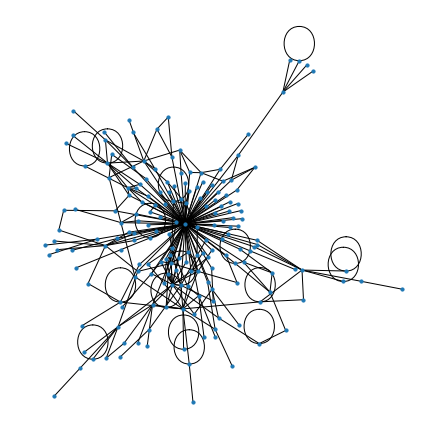

In [29]:
# Print some dataset statistics
print('Number of graphs:', len(dataset))
print('Number of features:', dataset.num_features)
print('Number of classes:', dataset.num_classes)

# Visualize one of the graphs using NetworkX
G = nx.Graph()
G.add_nodes_from(range(dataset[0].num_nodes))
G.add_edges_from(dataset[0].edge_index.t().tolist())

plt.figure(figsize=(6, 6))
nx.draw(G, node_size=10)
plt.show()